In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
path = '/home/bertinelli/pod_compastro23/Fireworks/fireworks_test'
data = np.load(path + '/data/ass_3/tstep_0.0001_e_0.99_rp_1.0.npz')


In [57]:
# data_000001 = data['1e-05'][::1000]
# data_00001 = data['0.0001']
data_0001 = data['RK4']

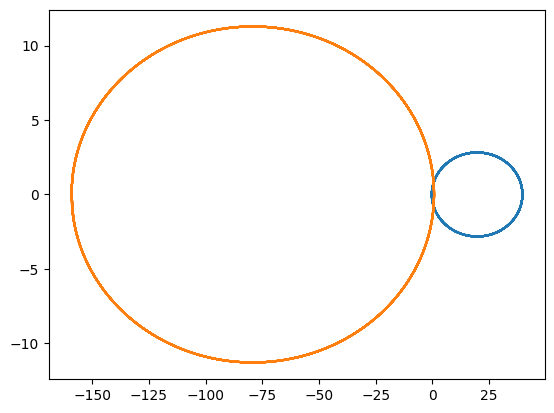

In [58]:
# plt.hist(data_0001[:,5])
plt.plot(data_0001[:,0], data_0001[:,1])
plt.plot(data_0001[:,2], data_0001[:,3])
# plt.xlim(-15, 15)
# plt.ylim(-15,15)
plt.show()

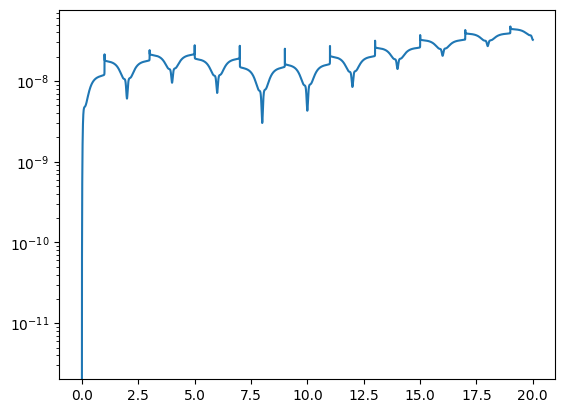

In [59]:
# plt.hist(data_0001[:,5])

plt.plot(np.linspace(0, 20, data_0001[:, 4].shape[0]), np.abs((data_0001[:,4]-data_0001[0,4])/(data_0001[0,4])))
plt.yscale('log')

(array([2.2109e+04, 6.6100e+02, 1.9800e+02, 8.6000e+01, 4.2000e+01,
        2.3000e+01, 1.5000e+01, 1.0000e+01, 7.0000e+00, 2.0000e+00,
        6.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00]),
 array([1.00000000e-04, 4.40541041e+00, 8.81072082e+00, 1.32160312e+01,
        1.76213416e+01, 2.20266521e+01, 2.64319625e+01, 3.08372729e+01,
        3.52425833e+01, 3.96478937e+01, 4.40532041e+01, 4.84585145e+01,
        5.28638249e+01, 5.72691354e+01, 6.16744458e+01, 6.60797562e+01,
        7.04850666e+01, 7.48903770e+01, 7.92956874e+01, 8.37009978e+01,
        8.81063082e+01]),
 <BarContainer object of 20 artists>)

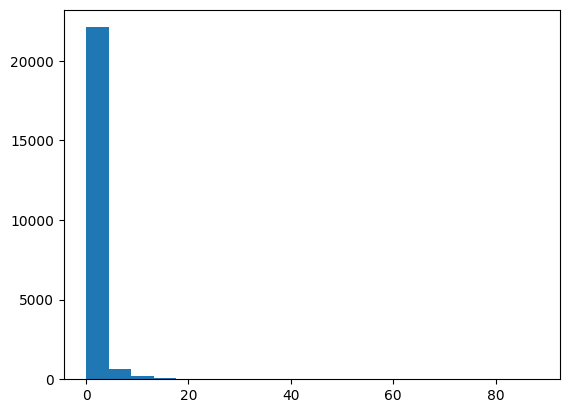

In [60]:
plt.hist(data_0001[:,5], bins=20)

In [44]:
unique_values = np.unique(np.round(data_0001[:,5], decimals=2))
count = len(unique_values)
print(count)

1134


In [2]:
import numpy as np
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from tqdm.notebook import tqdm

from fireworks.particles import Particles
import fireworks.ic as ic
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni
import fireworks.nbodylib.timesteps as fnt
np.random.seed(9725)

  0%|          | 0/1986 [00:00<?, ?it/s]

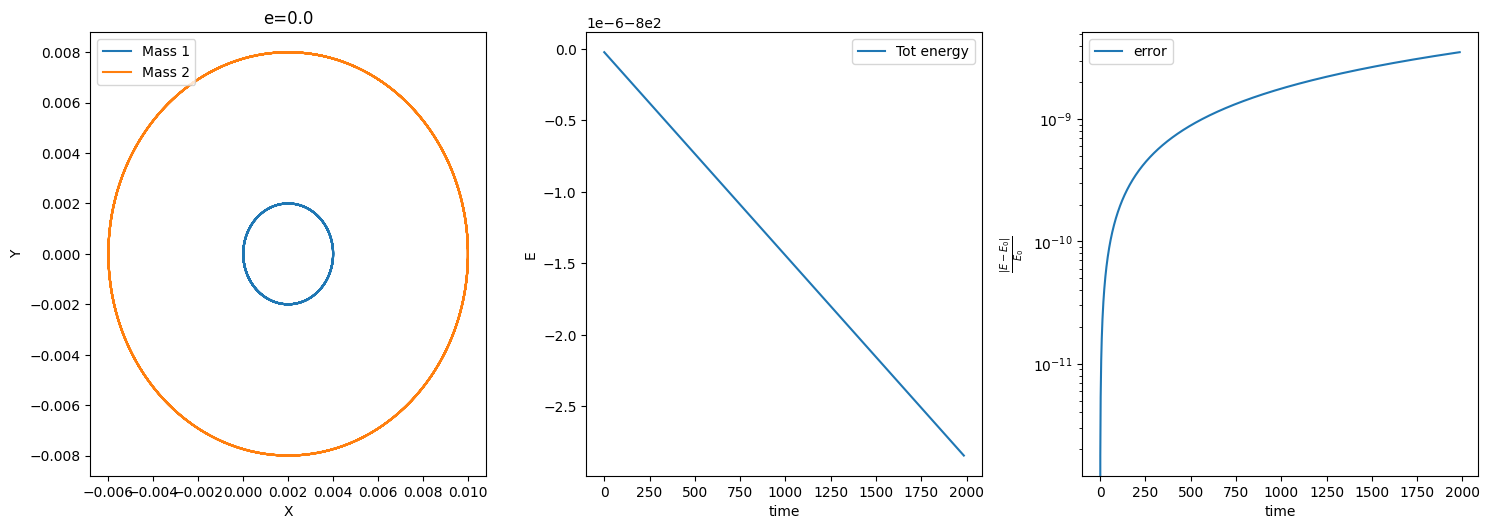

In [3]:
fig = plt.figure(figsize=(15, 15), layout='tight')
iplot = 330
# for e in [0.5, 0.9, 0.99]:
for e in [0.0]:
    rp = 0.01
    a = rp / (1 - e)
    part = ic.ic_two_body(mass1=8., mass2=2, e=e, rp=rp)
    Tperiod = 2 * np.pi * np.sqrt(a**3 / (part.mass[0] + part.mass[1]))
    N_end = 10
    dt = 0.00001
    tintermediate=np.linspace(start=0, stop=N_end*Tperiod, num=int(10*Tperiod/dt))
    N_ts = int(np.floor(N_end*Tperiod/dt))
    pos_list=[]
    vel_list=[]
    energy_list=[]
    tstep = []
    dt_copy = dt#.copy()
    tot_time = 0
    N_ts_cum = 0
    for t in tqdm(tintermediate):
        
        # particles, efftime,_,_,_= fni.integrator_tsunami(particles,tstep)
        part, dt_copy, acc, jerk,_= fni.integrator_rk4(part, dt_copy, acceleration_estimator=fnd.acceleration_direct_vectorized, args={'return_jerk': True})


        # Save the particles positions and velocities and energy
        pos_list.append(part.pos.copy())
        vel_list.append(part.vel.copy())
        Etot, _, _ = part.Etot()
        energy_list.append(Etot)
        # tstep.append(dt_copy)
        # dt_copy = fnt.adaptive_timestep(integrator=fni.integrator_rk4, int_args={'particles': part,
        #                                                                         'tstep': dt_copy,
        #                                                                         'acceleration_estimator': fnd.acceleration_direct_vectorized}, int_rank=4,
        #                             predictor=fni.integrator_heun, pred_args={'particles': part,
        #                                                                         'tstep': dt_copy,
        #                                                                         'acceleration_estimator': fnd.acceleration_direct_vectorized}, pred_rank=2,
        #                             epsilon = 1e-06)

        dt_copy = fnt.adaptive_timestep_jerk(acc=acc, jerk=jerk, eta=0.02)
        
        tstep.append(dt_copy)
        # Here we can save stuff, plot stuff, etc.
        tot_time += dt_copy
        N_ts_cum += 1

        if tot_time >= N_end*Tperiod:
            print('Exceeded time limit')
            break
        elif N_ts_cum >= 10*N_ts:
            print('Exceeded number of time steps')
            break

    
    pos_x_1, pos_y_1 = np.array(pos_list)[:, 0][:, 0], np.array(pos_list)[:, 0][:, 1] 
    pos_x_2, pos_y_2 = np.array(pos_list)[:, 1][:, 0], np.array(pos_list)[:, 1][:, 1] 

    #position plot
    iplot +=1
    ax = fig.add_subplot(iplot)
    ax.plot(pos_x_1, pos_y_1, label=f'Mass 1')
    ax.plot(pos_x_2, pos_y_2, label=f'Mass 2')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'e={e}')
    ax.legend()
    
    #energy plot
    iplot +=1
    ax = fig.add_subplot(iplot)
    ax.plot(energy_list, label='Tot energy')
    ax.set_xlabel('time')
    ax.set_ylabel('E')
    ax.legend()
    
    #energy error
    iplot +=1
    ax = fig.add_subplot(iplot)
    energy_array = np.array(energy_list)
    error = np.abs((energy_array - energy_array[0])/energy_array[0])
    ax.set_xlabel('time')
    ax.plot(error, label='error')
    ax.set_yscale('log')
    ax.set_ylabel(r'$\frac{|E-E_0|}{E_0}$')
    ax.legend()


In [6]:
np.min(tstep), np.max(tstep), np.mean(tstep), np.std(tstep)

(6.324555227105156e-06,
 6.32455532000856e-06,
 6.3245552721538355e-06,
 2.4087397291584996e-14)

Text(0.5, 1.0, 'Histogram of tstep')

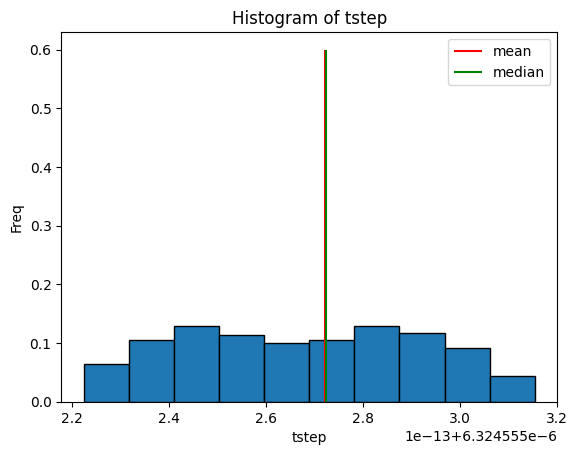

In [11]:
plt.hist(tstep, bins=10, density=False, edgecolor='black', weights=np.ones(len(tstep)) / len(tstep), align='left')
plt.vlines(np.mean(tstep), 0, 0.6, color='red', label='mean')
plt.vlines(np.median(tstep), 0, 0.6, color='green', label='median')
# plt.vlines(np.std(tstep), 0, 0.6, color='orange', label='std')
plt.legend()
plt.xlabel('tstep')
plt.ylabel('Freq')
# plt.xticks(np.arange(0.00001, 0.0008, 0.001))
plt.title('Histogram of tstep')
# plt.xticks(rotation='vertical', ha='center')
# plt.show()


In [12]:
unique_values = np.unique(np.round(tstep, decimals=7))
count = len(unique_values)
print(count)


1


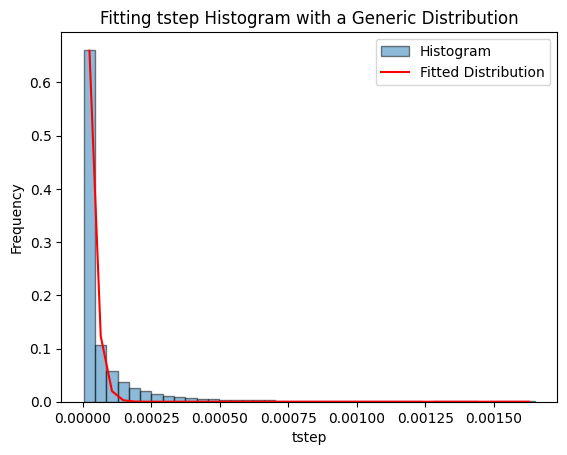

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Define the generic distribution function
def generic_distribution(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

# Fit the histogram with the generic distribution
hist, bins = np.histogram(tstep, bins=40, density=False, weights=np.ones(len(tstep)) / len(tstep))
bin_centers = (bins[:-1] + bins[1:]) / 2
popt, pcov = curve_fit(generic_distribution, bin_centers, hist)

# Plot the histogram and the fitted distribution
plt.hist(tstep, bins=40, density=False, edgecolor='black', alpha=0.5, label='Histogram', weights=np.ones(len(tstep)) / len(tstep))
plt.plot(bin_centers, generic_distribution(bin_centers, *popt), 'r-', label='Fitted Distribution')
plt.xlabel('tstep')
plt.ylabel('Frequency')
plt.legend()
plt.title('Fitting tstep Histogram with a Generic Distribution')
plt.show()


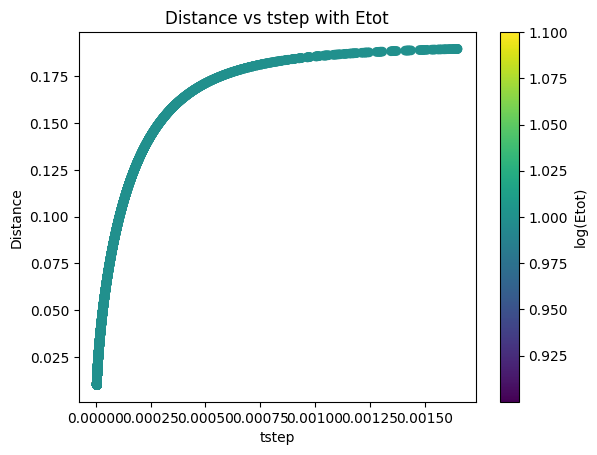

In [8]:
# Adding a small constant to avoid taking log of 0
energy_list = np.array(energy_list)  # Convert energy_list to numpy array
c = (energy_list + 1e-10)

# Or replacing negative values
# energy_list[energy_list <= 0] = 1  # replace with a suitable value
# c = np.log10(energy_list)
plt.scatter(tstep, np.sqrt((pos_x_1 - pos_x_2)**2 + (pos_y_1 - pos_y_2)**2), c=c)
plt.colorbar(label='log(Etot)')
plt.xlabel('tstep')
plt.ylabel('Distance')
plt.title('Distance vs tstep with Etot')
plt.show()


In [65]:
for i in range(1, 1000, 100):
    print(i)

1
101
201
301
401
501
601
701
801
901
